In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from cmcrameri import cm
import multiprocessing as mp
from atmosentry.meteoroid import Meteoroid
from atmosentry import Simulation

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


def set_size(width, fraction=1, subplots=(1, 1)):
    """
    Set figure dimensions to avoid scaling in LaTeX.
    This code is from: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
        width_pt = width_pt / 72.27

    elif width == 'beamer':
        width_pt = 307.28987
        width_pt = width_pt / 72.27

    else:
        width_pt = width

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    fig_width_in = width_pt * fraction
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

fig_width, fig_height = set_size('thesis')

In [3]:
def calc_D_crater(M_imp, D_imp, v_imp, theta_imp):
    """
    Docstring: calculate the diameter of transient crater produced during hypervelocity impact
    """

    rho_tar = 3e3

    return 1.677 * (M_imp ** 0.113) * (D_imp ** -0.22) * (rho_tar ** (-1/3)) * ((0.5 * M_imp * v_imp ** 2) ** 0.22) * (9.81 ** -0.22) * (np.sin(theta_imp) ** (1/3))


def plot_frags(R0, V0, color='k'):
    """
    Doctring: simulate the atmospheric entry of a comet with initial radius R0, initial velocity V0
    
    The location, and size of craters produced by the comet/its fragments are plotted to scale.
    """

    rho_com = 0.6e3
    theta0 = 45 * np.pi / 180

    M0 = rho_com * (4 * np.pi / 3) * (R0 ** 3)

    impactor = Meteoroid(x=0,
                            y=0,
                            z=100e3,
                            vx=-V0 * np.cos(theta0),
                            vy=0,
                            vz=-V0 * np.sin(theta0),
                            radius=R0,
                            mass=M0,
                            sigma=1e4,
                            rho=rho_com,
                            eta=2.5e6)

    sim = Simulation()
    sim.impactor = impactor
    sim.integrate()

    surface_frags = [frag for frag in sim.fragments if frag.state.z[-1] < 1]
    if len(surface_frags):

        x_coords = [frag.state.x[-1] for frag in surface_frags]
        y_coords = [frag.state.y[-1] for frag in surface_frags]

        x_bar = np.mean(x_coords)
        y_bar = np.mean(y_coords)

        for frag in surface_frags:

            v_imp = np.sqrt(frag.state.vx[-1] ** 2 + frag.state.vy[-1] ** 2 + frag.state.vz[-1] ** 2)
            D_crater = calc_D_crater(frag.state.mass[-1], 2 * frag.state.radius[-1], v_imp, np.arctan(frag.state.vz[-1] / frag.state.vx[-1]))

            plt.scatter(frag.state.x[-1] - x_bar, frag.state.y[-1] - y_bar, marker=None, facecolors='none')
            
            circle = plt.Circle((frag.state.x[-1] - x_bar, frag.state.y[-1] - y_bar), D_crater / 2, color=color, fill=False)
            plt.gca().add_patch(circle)

    else:

        x_bar = np.mean(impactor.state.x[-1])
        y_bar = np.mean(impactor.state.y[-1])

        v_imp = np.sqrt(impactor.state.vx[-1] ** 2 + impactor.state.vy[-1] ** 2 + impactor.state.vz[-1] ** 2)
        D_crater = calc_D_crater(impactor.state.mass[-1], 2 * impactor.state.radius[-1], v_imp, np.arctan(impactor.state.vz[-1] / impactor.state.vx[-1]))

        plt.scatter(impactor.state.x[-1] - x_bar, impactor.state.y[-1] - y_bar, color=color)

        circle = plt.Circle((impactor.state.x[-1] - x_bar, impactor.state.y[-1] - y_bar), D_crater / 2, color=color, fill=False)
        plt.gca().add_patch(circle)

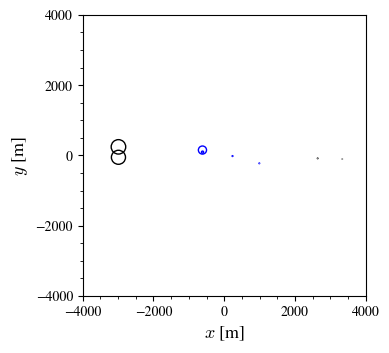

In [4]:
R0 = 100
V0 = 20e3

_ = plt.figure(figsize=(fig_height, fig_height))

# The crater field is plotted twice, to demonstrate the inherant uncertainty in fragment properties at the surface.
plot_frags(R0, V0, 'k')
plot_frags(R0, V0, 'b')

plt.minorticks_on()

x_limits = plt.gca().get_xlim()
y_limits = plt.gca().get_ylim()

max_lims = [max(x_limits), max(y_limits)]

plt.xlim(-max(max_lims), max(max_lims))
plt.ylim(-max(max_lims), max(max_lims))

ticks = plt.gca().get_xticks()
plt.xticks(ticks)
plt.yticks(ticks)

plt.xlabel(r'$x$ [m]', fontsize=13)
plt.ylabel(r'$y$ [m]', fontsize=13)

# plt.savefig('./paper/figures/crater_field.pdf', bbox_inches='tight', format='pdf')

plt.show()